In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # or if you want more than 1 GPU set it as "0", "1"

In [3]:
import pandas as pd 
import numpy as np 
import re,string
from bs4 import BeautifulSoup

In [4]:
from nltk import sent_tokenize, word_tokenize
from nltk import bigrams, trigrams
from nltk import WordNetLemmatizer

from nltk.util import ngrams, pad_sequence
from collections import Counter, defaultdict
from nltk.corpus import stopwords

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import losses
from tensorflow.keras import backend
from tensorflow.keras import callbacks

In [6]:
ftrain=open("train.txt", "r",encoding="utf-8")
text_raw = ftrain.read()

In [7]:
len(text_raw)

5034054

In [8]:
#text_raw = text_raw[:200000]

In [9]:
def prepare_text(text_raw):
    text = text_raw
    # replace \n characters with space
    text=re.sub('\n',' ',text)
    # remove html tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()  
    # convert to lower case
    text = text.lower()

    text_sents = sent_tokenize(text)

    all_tokens = []
    text_sents_cleaned = []
    tokenized_word_sents = []
    for s in text_sents:
        s_cleaned = re.sub("[^a-zA-Z]", " ", s)
        s_words = word_tokenize(s_cleaned)
        for t in s_words:
            all_tokens.append(t)
        if(len(s_words) > 0):
            text_sents_cleaned.append(s_cleaned)
            tokenized_word_sents.append(s_words)

    all_tokens.append('none')
    all_tokens.append('None')
    all_tokens.append('<s>')
    all_tokens.append('</s>')

    print("len of all sentences: ",len(tokenized_word_sents))
    print("len of all tokens: ",len(all_tokens))
    return all_tokens, text_sents_cleaned, tokenized_word_sents

In [10]:
all_tokens, text_sents_cleaned, tokenized_word_sents = prepare_text(text_raw)

len of all sentences:  42801
len of all tokens:  839510


In [11]:
# sample sentence

print("first sentence:\n" , text_sents_cleaned[0])
s_words = word_tokenize(text_sents_cleaned[0])
print("\nwords of first sentence:\n" , s_words)
s_padded = pad_sequence(s_words,pad_left=True,left_pad_symbol="<s>",pad_right=True,right_pad_symbol="</s>",n=2)
print("\npadded words of first sentence:\n" , list(s_padded))


first sentence:
 many are the hours in which i have pondered upon the story that is set forth in the following pages 

words of first sentence:
 ['many', 'are', 'the', 'hours', 'in', 'which', 'i', 'have', 'pondered', 'upon', 'the', 'story', 'that', 'is', 'set', 'forth', 'in', 'the', 'following', 'pages']

padded words of first sentence:
 ['<s>', 'many', 'are', 'the', 'hours', 'in', 'which', 'i', 'have', 'pondered', 'upon', 'the', 'story', 'that', 'is', 'set', 'forth', 'in', 'the', 'following', 'pages', '</s>']


In [12]:
def build_glove_word2vec():
    from gensim.test.utils import datapath, get_tmpfile
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec

    glove_file = datapath('F:\\Projects\\CA-3\\glove.6B.50d.txt')
    tmp_file = get_tmpfile('F:\\Projects\\CA-3\\word2vec.txt')

    word2vec_shape = glove2word2vec(glove_file, tmp_file)

    print("word2vec_shape --> num_lines , dims : " , word2vec_shape)
    word2vec_model = KeyedVectors.load_word2vec_format(tmp_file)
    return word2vec_model

In [13]:
word2vec_model = build_glove_word2vec()

word2vec_shape --> num_lines , dims :  (400000, 50)


In [14]:
print("words similar to \"iran\":\n",word2vec_model.most_similar(positive=['iran'], topn=10))
print("\nsimilarity between cat , dog vectors: " , word2vec_model.similarity('cat', 'dog'))
print("\nembedding vector for word \"unk\":\n", word2vec_model.get_vector("unk"))

words similar to "iran":
 [('tehran', 0.8854164481163025), ('syria', 0.8548012971878052), ('iranian', 0.8462818264961243), ('nuclear', 0.8353855013847351), ('korea', 0.8068287968635559), ('pyongyang', 0.8059216141700745), ('iraq', 0.795691728591919), ('arabia', 0.768294095993042), ('libya', 0.7636364102363586), ('pakistan', 0.7614778876304626)]

similarity between cat , dog vectors:  0.92180055

embedding vector for word "unk":
 [-7.9149e-01  8.6617e-01  1.1998e-01  9.2287e-04  2.7760e-01 -4.9185e-01
  5.0195e-01  6.0792e-04 -2.5845e-01  1.7865e-01  2.5350e-01  7.6572e-01
  5.0664e-01  4.0250e-01 -2.1388e-03 -2.8397e-01 -5.0324e-01  3.0449e-01
  5.1779e-01  1.5090e-02 -3.5031e-01 -1.1278e+00  3.3253e-01 -3.5250e-01
  4.1326e-02  1.0863e+00  3.3910e-02  3.3564e-01  4.9745e-01 -7.0131e-02
 -1.2192e+00 -4.8512e-01 -3.8512e-02 -1.3554e-01 -1.6380e-01  5.2321e-01
 -3.1318e-01 -1.6550e-01  1.1909e-01 -1.5115e-01 -1.5621e-01 -6.2655e-01
 -6.2336e-01 -4.2150e-01  4.1873e-01 -9.2472e-01  1.1049

In [15]:
def build_encoder(all_tokens):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(all_tokens)
    #vocab_size = len(label_encoder.classes_)
    #print("vocab_size: ", vocab_size)

    # binary encode
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = OneHotEncoder(sparse=False, dtype='uint8')
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return label_encoder, onehot_encoder


In [16]:
label_encoder, onehot_encoder = build_encoder(all_tokens)

vocab_size = len(label_encoder.classes_)
print("vocab_size: ", vocab_size)

# invert first example
print("invert of code 4: ", label_encoder.inverse_transform([4]))
print("transform of word \"the\" to code: ", label_encoder.transform(["the"]))
d = onehot_encoder.transform([label_encoder.transform(["the"])])
print("one-hot vector of word \"the\": ", d[0])

vocab_size:  57500
invert of code 4:  ['aa']
transform of word "the" to code:  [51144]
one-hot vector of word "the":  [0 0 0 ... 0 0 0]


In [17]:
def generate_file_ngram_X_Y(onehot_encoder, label_encoder, tokenized_word_sents, file_name):
    file_data = open(file_name, "ab")    
    count = 0
    countError = 0
    for sentence in tokenized_word_sents:    
        #s_padded = pad_sequence(sentence,pad_left=True,left_pad_symbol="<s>",pad_right=True,right_pad_symbol="</s>",n=2)
        for w1, w2, w3, w4, w5 in ngrams(sentence, pad_right=True, pad_left=True,n=5):
            count += 1
            #print(w1, w2, w3, w4, w5)
            try:
                v1 = list(word2vec_model.get_vector(str(w1).lower()))
                v2 = list(word2vec_model.get_vector(str(w2).lower()))
                v3 = list(word2vec_model.get_vector(str(w3).lower()))
                v4 = list(word2vec_model.get_vector(str(w4).lower()))
                y_word = str(w5).lower()
                index_y_word = [label_encoder.transform([y_word])]
                np.savetxt(file_data, [v1+v2+v3+v4+index_y_word], fmt="%2.6f",delimiter=",")
            except:
                #print('Error during get vector for:{} {} {} {} {}'.format(w1, w2, w3, w4, w5))
                countError+=1
                pass
    print("count of 5-grams={}".format(count))        
    print("count on unknown 5-grams={}".format(countError)) 
    file_data.close()
    return

In [18]:
#generate_file_ngram_X_Y(onehot_encoder, label_encoder, tokenized_word_sents, "train_5gram_vectors.csv")

In [19]:
some_data = np.loadtxt('train_5gram_nopad_vectors.csv',delimiter=',',skiprows=100000,max_rows=20)

example = some_data[4]

tmp_X_w1=example[:50]
tmp_X_w2=example[50:100]
tmp_X_w3=example[100:150]
tmp_X_w4=example[150:200]
tmp_Y = example[200]
print("\nlen of w1,w2,w3,w4,w5 vectors:")
print(len(tmp_X_w1),len(tmp_X_w2),len(tmp_X_w3),len(tmp_X_w4),tmp_Y)
print([tmp_X_w1])
print ("X --> w1:", word2vec_model.most_similar(positive=[tmp_X_w1], topn=1))
print ("X --> w2:", word2vec_model.most_similar(positive=[tmp_X_w2], topn=1))
print ("X --> w3:", word2vec_model.most_similar(positive=[tmp_X_w3], topn=1))
print ("X --> w4:", word2vec_model.most_similar(positive=[tmp_X_w4], topn=1))
print ("Y --> w5: ", label_encoder.inverse_transform([[int(tmp_Y)]]))

y1=np.array([int(tmp_Y)])
d = onehot_encoder.transform(y1.reshape(-1, 1))
one_hot_y = list(d[0])
print(np.argmax(one_hot_y))
#print(one_hot_y)


len of w1,w2,w3,w4,w5 vectors:
50 50 50 50 494.0
[array([ 0.17428 , -0.6233  , -0.44818 ,  0.60294 , -0.94306 , -1.0494  ,
        0.92046 ,  0.19768 ,  0.12662 , -0.52371 ,  0.35727 , -0.31895 ,
       -0.14491 , -1.8892  ,  0.10333 , -0.32712 , -0.64275 ,  0.28799 ,
       -0.17667 ,  0.32841 , -0.29234 , -0.75986 , -0.41077 , -0.3366  ,
        0.025411, -0.24726 ,  0.14494 ,  0.45001 , -0.31575 , -0.16851 ,
       -1.0089  , -0.083239, -0.17766 , -0.49297 , -0.19273 ,  0.22679 ,
       -1.1536  ,  0.77109 , -0.061446,  0.081545,  0.33615 ,  0.64235 ,
        0.63767 , -1.3452  , -0.44798 , -0.681   ,  0.98865 , -0.64553 ,
        0.66982 , -0.16452 ])]
X --> w1: [('belfort', 0.9999999403953552)]
X --> w2: [('and', 0.9999998807907104)]
X --> w3: [('at', 1.0)]
X --> w4: [('the', 1.0)]
Y --> w5:  ['activities']
494


In [20]:
train_data = np.loadtxt('train_5gram_nopad_vectors.csv', delimiter=',')

In [21]:
num_train_5grams = len(train_data)
print(num_train_5grams)

641293


In [22]:
test_data = np.loadtxt('test_5gram_nopad_vectors.csv', delimiter=',')

In [23]:
num_test_5grams = len(test_data)
print(num_test_5grams)

22143


In [24]:
#print(history.history['val_perplexity'])
def perplexity(y_true, y_pred):
    cross_entropy = losses.categorical_crossentropy(y_true, y_pred)
    perplexity = backend.pow(2.0, cross_entropy)
    return perplexity

In [25]:
from tensorflow.keras.optimizers import SGD

def build_model(input_dim, vocab_size, hidden_units, learning_rate):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(vocab_size, activation='softmax'))
    sgd = SGD(lr=learning_rate, momentum=0., decay=0., nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[perplexity])
    return model

In [26]:
class ReportCallback(callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: perplexity={}, loss={}, val_perplexity={}, val_loss={},".format(
                epoch, logs["perplexity"], logs["loss"], logs["val_perplexity"], logs["val_loss"]))

In [27]:
import random 
def generator_batch (input_size, vocab_size, ngrams_data, batch_size, num_data):
    batch_features = np.zeros((batch_size, input_size))
    batch_labels = np.zeros((batch_size,vocab_size))        
    while True:
        index = random.randrange(num_data-batch_size-1)
        #selected_data = np.loadtxt(csv_filename, delimiter=',', skiprows=index, max_rows=batch_size)
        selected_data = ngrams_data[index:index+batch_size]
        for i in range(len(selected_data)):
            batch_features[i] = selected_data[i][:input_size]
            y1= np.array([int(selected_data[i][input_size])])
            d = onehot_encoder.transform(y1.reshape(-1, 1))
            batch_labels[i] = list(d[0])                       
        
        yield batch_features, batch_labels   

In [28]:
print("num_train_5grams:", num_train_5grams)
print("num_test_5grams:", num_test_5grams)
input_size = len(train_data[0])-1
print("input_size:", input_size)
print("vocab_size:", vocab_size)
batch_size = 32
steps_per_epoch = int(num_train_5grams/batch_size)
validation_steps = int(num_test_5grams/batch_size)
print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

num_train_5grams: 641293
num_test_5grams: 22143
input_size: 200
vocab_size: 57500
steps_per_epoch: 20040
validation_steps: 691


In [29]:
model = build_model(input_size, vocab_size,hidden_units=100, learning_rate=0.02)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 57500)             5807500   
Total params: 5,827,600
Trainable params: 5,827,600
Non-trainable params: 0
_________________________________________________________________


In [30]:
def train_model(model, model_filepath, pretrained_weights, epoch_num):
    if (pretrained_weights == True):
        model.load_weights(model_filepath)
    #--------------------------------------
    checkpointer = ModelCheckpoint(model_filepath, monitor='val_perplexity', verbose=1, save_best_only=True, mode='min')

    metrics = model.fit_generator(generator_batch(input_size, vocab_size, train_data, batch_size, num_train_5grams), 
                              steps_per_epoch=1000, 
                              validation_data=generator_batch(input_size, vocab_size, test_data, batch_size, num_test_5grams), 
                              validation_steps=30, 
                              epochs=epoch_num, verbose=0, callbacks=[ReportCallback(),checkpointer], workers=10,shuffle=True)    
    return metrics

In [31]:
model_filepath = 'model_lm_5w_100n_lr_02_glove.hdf5'
metrics = train_model(model, model_filepath, pretrained_weights=False, epoch_num=25)

Epoch 0: perplexity=1472.150744934082, loss=9.302834557533265, val_perplexity=1490.6123779296875, val_loss=8.95829823811849,

Epoch 00001: val_perplexity improved from inf to 1490.61238, saving model to model_lm_5w_100n_lr_02_glove.hdf5
Epoch 1: perplexity=1356.0300849609375, loss=8.489864208221436, val_perplexity=1410.8836547851563, val_loss=8.706092151006063,

Epoch 00002: val_perplexity improved from 1490.61238 to 1410.88365, saving model to model_lm_5w_100n_lr_02_glove.hdf5
Epoch 2: perplexity=1279.1088541870117, loss=8.245824823856355, val_perplexity=1268.1191874186197, val_loss=8.409646685918172,

Epoch 00003: val_perplexity improved from 1410.88365 to 1268.11919, saving model to model_lm_5w_100n_lr_02_glove.hdf5
Epoch 3: perplexity=1215.7940739135743, loss=8.065122240543365, val_perplexity=1249.4323669433593, val_loss=8.23073541323344,

Epoch 00004: val_perplexity improved from 1268.11919 to 1249.43237, saving model to model_lm_5w_100n_lr_02_glove.hdf5
Epoch 4: perplexity=1211.4

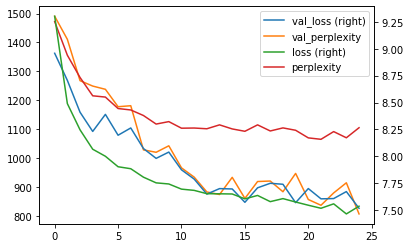

In [32]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

In [33]:
perp_trfile = open('perp_train_lm_5w_100n_lr_02_glove.csv', "ab")    
np.savetxt(perp_trfile, metrics.history.get('perplexity'), fmt="%2.6f",delimiter=",")
perp_trfile.close()

In [34]:
perp_tsfile = open('perp_test_lm_5w_100n_lr_02_glove.csv', "ab")    
np.savetxt(perp_tsfile, metrics.history.get('val_perplexity'), fmt="%2.6f",delimiter=",")
perp_tsfile.close()

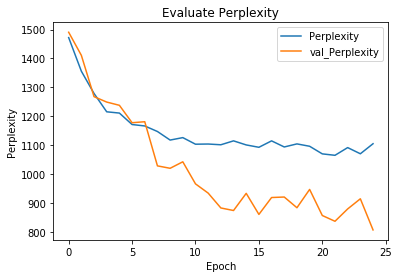

In [1]:
import matplotlib.pyplot as plt
import numpy as np

train_perp = np.loadtxt('perp_train_lm_5w_100n_lr_02_glove.csv', delimiter=',')
test_perp = np.loadtxt('perp_test_lm_5w_100n_lr_02_glove.csv', delimiter=',')

x1 = np.array(range(len(train_perp)))
x2 = np.array(range(len(test_perp)))

# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, train_perp, color='tab:blue', label='Perplexity')
ax.plot(x2, test_perp, color='tab:orange', label='val_Perplexity')

ax.set_title("Evaluate Perplexity")
ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
plt.legend(loc="upper right")
plt.show()
